In [1]:
import pandas as pd
import tensorflow as tf


from collections import OrderedDict
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive
from datasets.femto_bearing import FEMTOBearingsDataset
from minigraphnets import Edge,Node, Graph

import pandas as pd


not running in colab.


## Inspect held-out set performance:


In [2]:
p = pd.read_pickle("models/runs_dataframe")
p['min_val_loss'] = p['losses'].apply(lambda x : np.min(x['val_loss']))

In [3]:
pp = p.set_index(["network_size_global",'edge_node_state_size']).loc[15,100].reset_index() #['model_path','min_val_loss']

/home/charilaos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


In [25]:
model_row = pp.sort_values("min_val_loss").iloc[1]
model_row

network_size_global                                                                15
edge_node_state_size                                                              100
use_prenetworks                                                                  True
graph_function_output_activation                                                 relu
learning_rate                                                                   0.001
schedule_nnodes                                                             [1, 2, 5]
schedule_min_sep                                                             [10, 20]
nseq_length                                                                     [100]
iterations_schedule                                                               [5]
epochs                                                                            300
batch                                                                             300
rand_seed                                             

In [26]:
from graphnet_utils import GraphNetFunctionFactory, GraphNet

gn_tot = GraphNetFunctionFactory.make_from_record(model_row)
#gg = g.load(model_row['model_path'])
gn_tot.load(model_row['model_path'])

loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/node_function
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/edge_aggregation_function
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/edge_function
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/core/node_to_prob
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/node_function
path models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/edge_aggregation_function does not exist! Function edge_aggregation_function will not be constructed.
loading models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/edge_function
path models/e1f68f39d80a67914e0d35510aabd94a.graphnet/graph_independent/node_to_prob does not exist! Function node_to_prob will not be constructed.


In [27]:
femto_dataset = FEMTOBearingsDataset()

training set:
01 0 2_2 1502
05 0 1_1 1802
06 0 2_7 2302
07 1 1_5 1202
08 0 3_2 1139
09 1 2_1 2002
13 1 1_7 911
15 0 1_4 2803

testing set:
16 0 1_3 2302
02 2 2_5 1637


## Plotting the held-out experiments:

In [28]:
# all_weights = gn_tot.weights()
# gn_tot_copy = GraphNetFunctionFactory.make_from_record(model_row); 
# gn_tot.make_graphnet_comp_blocks(femto_dataset.X[0].shape[0])
# gn_tot_copy.set_weights(all_weights)

In [29]:
self = gn_tot

def eval_graphnets(graph_data_, iterations = 5, eval_mode = "batched", return_reparametrization = True):
    """
    graph_data_  : is a "graph" object that contains a batch of graphs (more correctly, a graph tuple as DM calls it)
    iterations   : number of core iterations for the computation.
    return_distr_params : return the distribution parameters instead of the distribution itself. This is in place because of some buggy model loading (loaded models don't return distribution objects).
    """
    graph_out = self.graph_indep.graph_eval(graph_data_,eval_mode = eval_mode)
    for iterations in range(iterations):
        graph_out = self.core.graph_eval(graph_out, eval_mode = eval_mode) + graph_out # Addition adds all representations (look at implementation of "Graph")

    # Finally the node_to_prob returns a reparametrized "Gamma" distribution from only the final node state
    if not return_reparametrization:
        return self.core.node_to_prob_function(graph_out.nodes[-1].node_attr_tensor)
    else:
        v = self.core.node_to_prob_function.get_layer("output")(graph_out.nodes[-1].node_attr_tensor)
        return _instantiate_gamma(v)

def _instantiate_gamma(t, NParams_ = 1):
    return tfd.Gamma(concentration = t[...,0:NParams_], rate = t[...,NParams_:2*NParams_])

    

In [31]:
#keras.Model(inputs = gn_tot.core.node_to_prob_function.inputs,outputs= gn_tot.core.node_to_prob_function.get_layer("output"))


In [32]:
model_row


network_size_global                                                                15
edge_node_state_size                                                              100
use_prenetworks                                                                  True
graph_function_output_activation                                                 relu
learning_rate                                                                   0.001
schedule_nnodes                                                             [1, 2, 5]
schedule_min_sep                                                             [10, 20]
nseq_length                                                                     [100]
iterations_schedule                                                               [5]
epochs                                                                            300
batch                                                                             300
rand_seed                                             

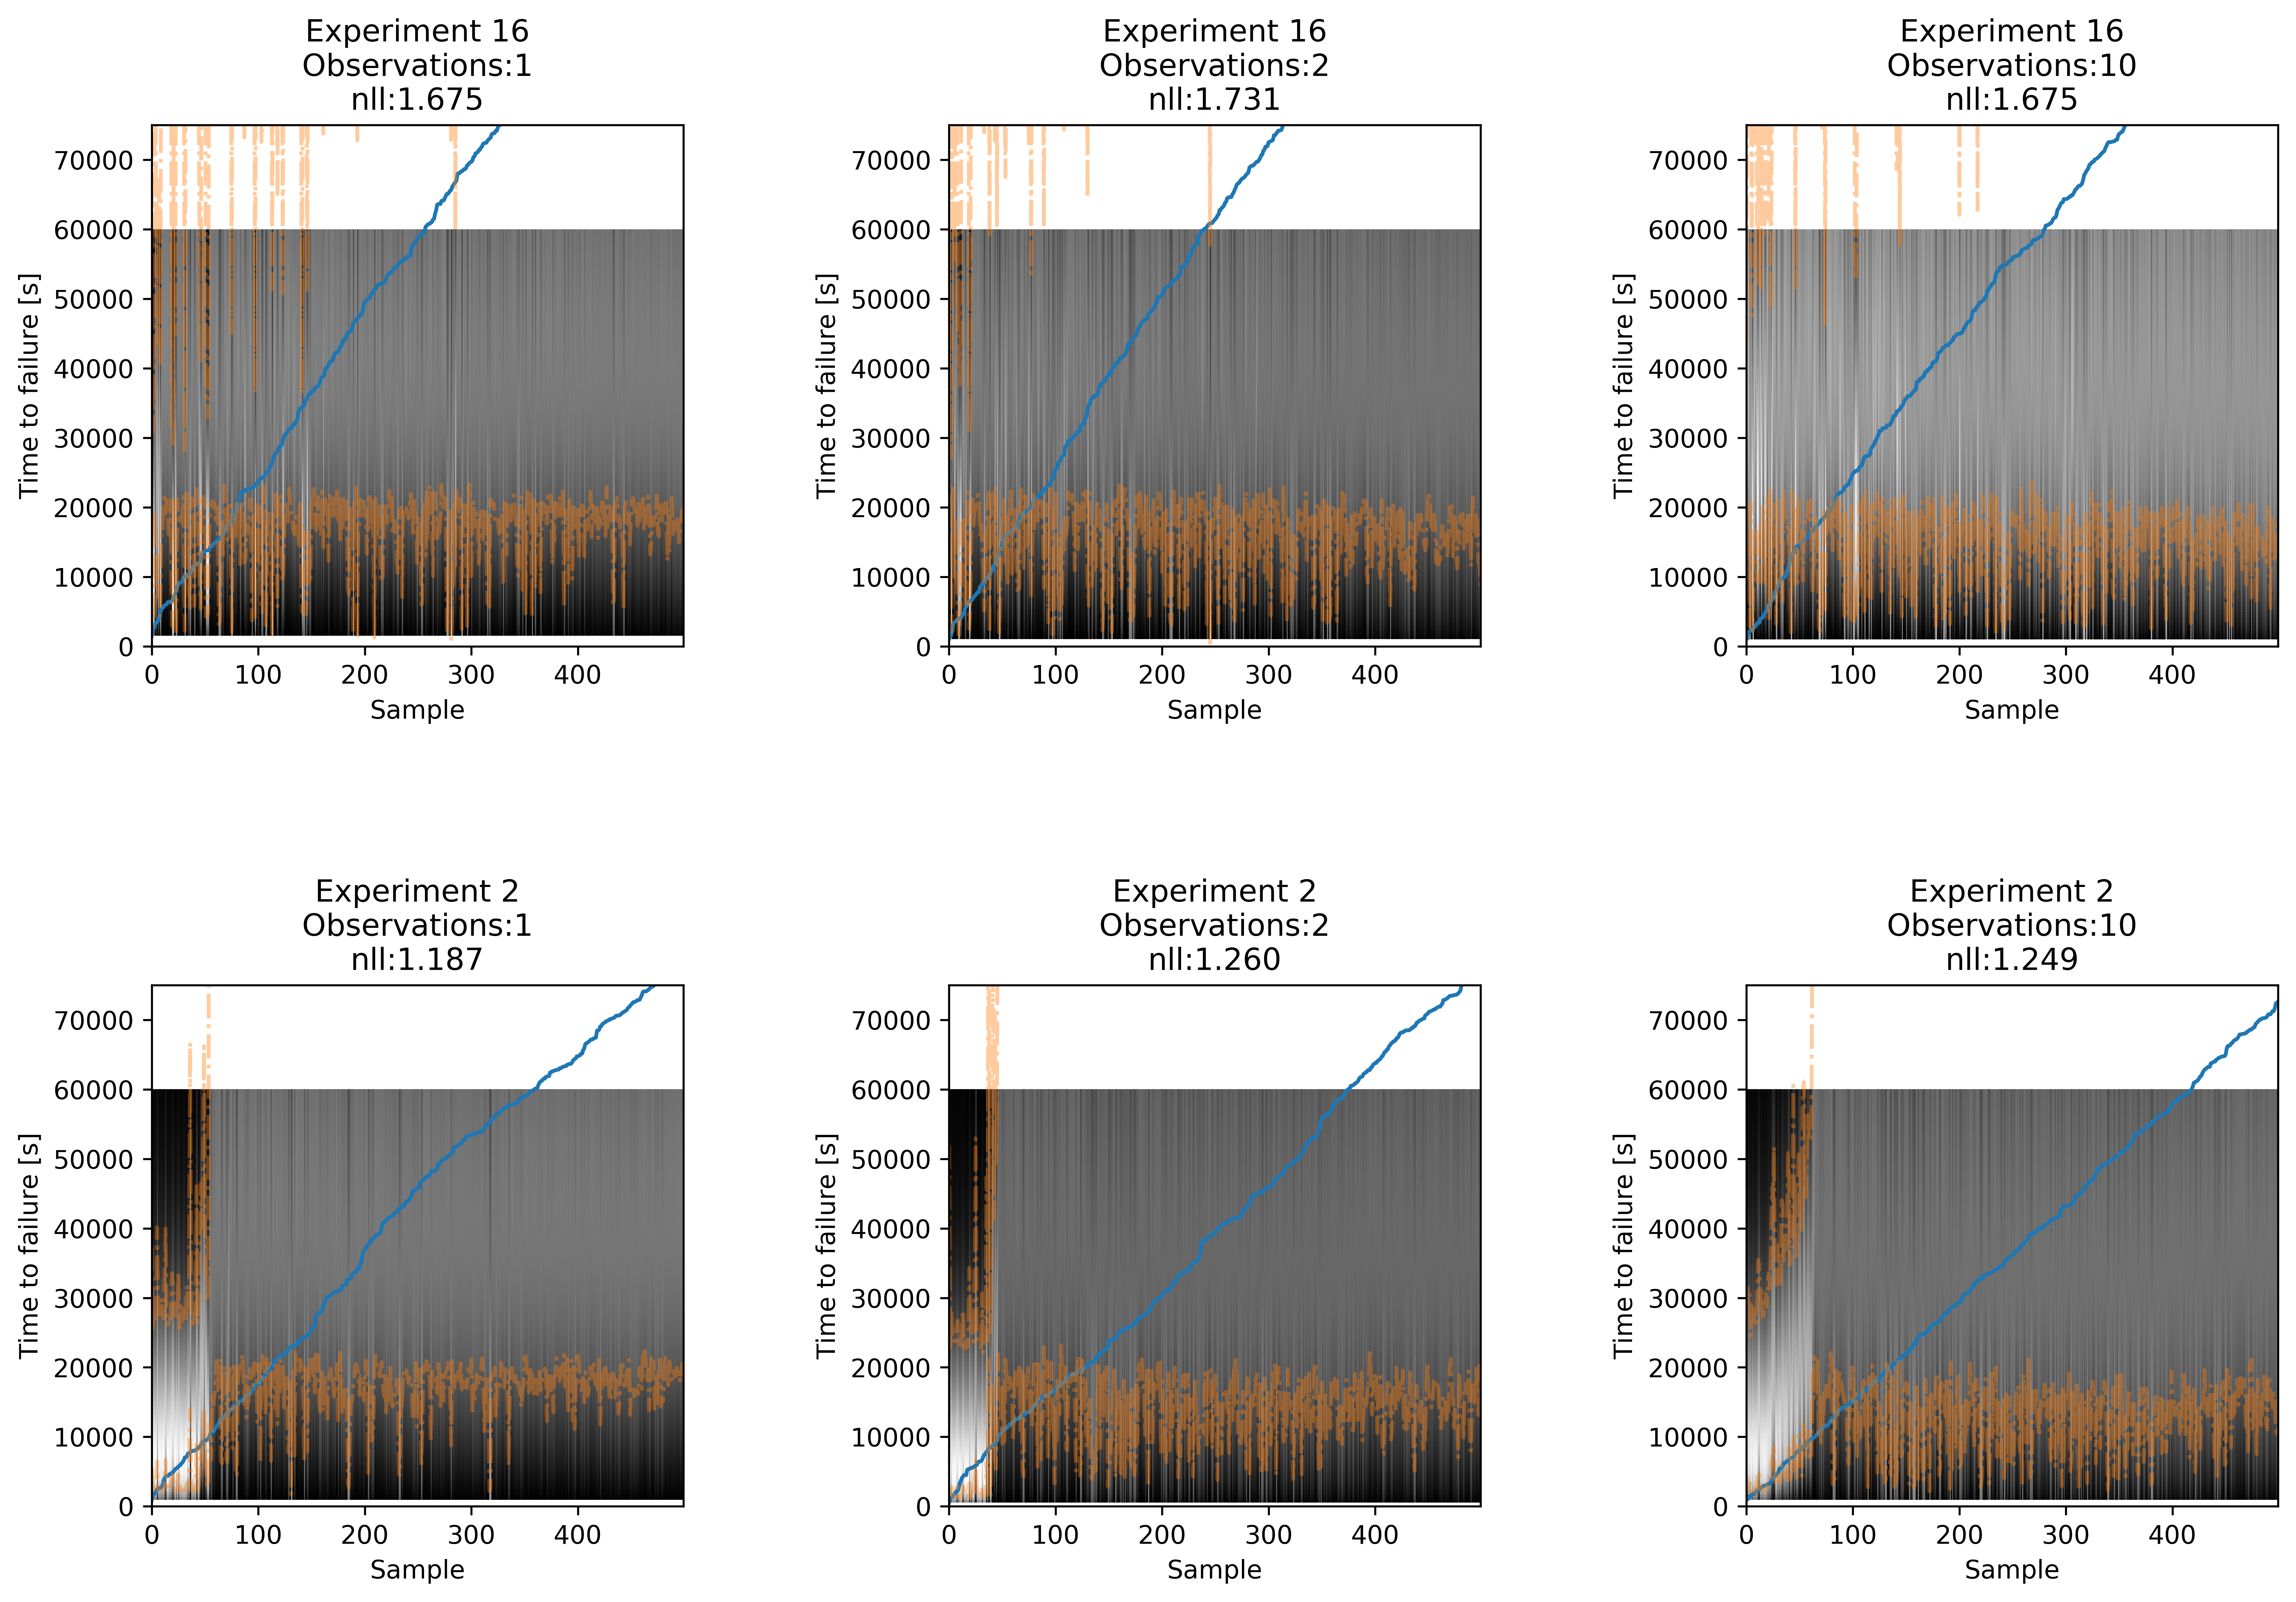

source:


<Figure size 432x288 with 0 Axes>

In [ ]:

from utils import get_graph_data
experiments_to_plot = [1]
def plot_experiments(experiments_to_plot):
#if True:
    
    #training = inds_exp_source
    nsampled = 500

    pplot.figure(figsize = (15,10), dpi = 600)
    nnodes_list = [1,2,10]
    nseq_len = [100,100,200]
    minspacing= [10,10,20]
    gnsteps  = [ 5,5,5]
    
    normalization_factor_time = femto_dataset.normalization_factor_time
    kk = 0;
    for ee in experiments_to_plot:
        for nnodes, gnsteps_,nseq_,minspacing_ in zip(nnodes_list, gnsteps, nseq_len, minspacing):
            #ee = training[0]
            graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                             yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                             nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                             nseq_range=nseq_)
            probs = eval_graphnets(graphs,gnsteps_, eval_mode="safe")
            #eval_graphnets()
            ids_sorted = np.argsort(y_times)
            time_grid = np.linspace(np.min(y_times),np.max(y_times), 150);
            time_grid = np.linspace(np.min(y_times), 60000./normalization_factor_time, 150)
            #time_grid = np.linspace(np.min(y_times),3.5, 150);
            
            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T

            y_times_sorted = y_times[ids_sorted];
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            pplot.pcolor([r for r in range(p_y.shape[1])], time_grid*normalization_factor_time, p_y[:,ids_sorted]**0.5, cmap = "gray")
            pplot.plot(y_times_sorted  *normalization_factor_time)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]

            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            pplot.plot(q90*femto_dataset.normalization_factor_time,'C1-.', alpha = 0.4)
            pplot.ylim(0,75000)
            pplot.xlabel("Sample")
            pplot.ylabel("Time to failure [s]")

            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))

            title = "Experiment %i\n Observations:%i \nnll:%2.3f"%(ee,nnodes,nll)
            pplot.title(title)
            kk+=1
            #p_y.shape
            #pplot.show()
    pplot.subplots_adjust(hspace = 0.65, wspace = 0.5)
    pplot.show()
    
#unseen =  inds_exp_source[3:6]#[4:7]#inds_exp_source[0:3] #inds_exp_target[0:3]

plot_experiments(femto_dataset.inds_exp_target)
pplot.savefig("graphnet_result_testset.png")
print("source:")
plot_experiments(femto_dataset.inds_exp_source[0:3])
pplot.savefig("graphnet_result_trainset.png")

In [20]:
femto_dataset.exp_to_cond_dict[2]

2

In [12]:
#femto_dataset.inds_exp_source
#t = graphs.nodes[0].node_attr_tensor
#graphs.node_times[0]
graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                 yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                 nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                 nseq_range=nseq_)

g = graphs.copy() 
res = gn_tot.graph_indep.node_function({'timeseries_input' : g.nodes[0].node_attr_tensor,'edge_input_dummy' : np.random.randn(123,654)})
res 
#gn_tot.graph_indep.node_function.summary()

NameError: name 'ee' is not defined

In [83]:
gn_tot.graph_indep.graph_eval(g.copy())

ResourceExhaustedError: OOM when allocating tensor with shape[1000,1,2559,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [13]:
graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                 yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                 nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                 nseq_range=nseq_)
probs = gn_tot.eval_graphnets(graphs,gnsteps_)

In [29]:
nm = gn_tot.core.node_to_prob_function
tf.keras.Model(inputs = nm.get_layer("output").input , outputs = nm.get_layer("distribution_lambda").output)

AttributeError: Layer output is not connected, no input to return.

In [40]:
v = nm.get_layer("output")(np.random.randn(10,100))
#help(tfd.Gamma)
NParams = 1
def instantiate_gamma(t):
    return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])

instantiate_gamma(v).

<tfp.distributions.Gamma 'Gamma' batch_shape=[10, 1] event_shape=[] dtype=float32>

In [29]:
#gi = GraphNet.make_from_path("models/5b64ab40b6b31abd39e2b5f0baa5c02f.graphnet/graph_independent/")
p


,network_size_global,edge_node_state_size,use_prenetworks,graph_function_output_activation,learning_rate,schedule_nnodes,schedule_min_sep,nseq_length,iterations_schedule,epochs,...,rand_seed,losses,model_path,training_set,validation_set,time_finished,time_started,experiment_metadata_id,experiment_metadata_desc,min_val_loss
0,15,100,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.681216, 12.4196415, 12.125812, 12...",models/e1f68f39d80a67914e0d35510aabd94a.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:36:33,17/07/2020 17:31:14,1,Figure out if gated_tanh is beneficial. See ef...,8.155869
0,15,50,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.678629, 12.432165, 12.104069, 12....",models/e510078b1dc351b5d7545f0845048604.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:31:02,17/07/2020 17:20:44,1,Figure out if gated_tanh is beneficial. See ef...,5.334609
0,15,30,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.6748495, 12.328814, 11.921677, 12...",models/a97500725b6638661f2ae8c2916c3874.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:20:32,17/07/2020 17:09:18,1,Figure out if gated_tanh is beneficial. See ef...,5.032773
0,30,100,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.679728, 12.402312, 12.053793, 12....",models/64078edc495da35313291f2d9b9adc5a.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:09:06,17/07/2020 17:02:22,1,Figure out if gated_tanh is beneficial. See ef...,5.962331
0,30,50,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.714354, 12.411136, 11.961258, 12....",models/60b6fa6972645742e63b715745bdcdeb.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 17:02:09,17/07/2020 16:54:33,1,Figure out if gated_tanh is beneficial. See ef...,5.331145
0,30,30,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.648668, 12.312098, 11.927065, 12....",models/6aab9972790ae0c0b72303a349f578ef.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:54:21,17/07/2020 16:44:33,1,Figure out if gated_tanh is beneficial. See ef...,5.170611
0,30,30,True,relu,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.614351, 12.295605, 11.809038, 12....",models/7345e22b4989acd8d7a5b260bdf2e788.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:23:18,17/07/2020 16:16:27,1,Figure out if gated_tanh is beneficial. See ef...,6.398033
0,15,100,True,tanh,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.676195, 12.412785, 12.11718, 12.6...",models/5b64ab40b6b31abd39e2b5f0baa5c02f.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:16:14,17/07/2020 16:12:10,1,Figure out if gated_tanh is beneficial. See ef...,9.310575
0,15,50,True,tanh,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.64727, 12.335764, 12.018303, 12.6...",models/c5a4edafec1859bccab5bd0f06e3107e.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:11:57,17/07/2020 16:09:25,1,Figure out if gated_tanh is beneficial. See ef...,11.344099
0,15,30,True,tanh,0.001,"[1, 2, 5]","[10, 20]",[100],[5],300,...,42,"{'loss': [12.674736, 12.33642, 12.009453, 12.6...",models/a2b8dc034482061f6e6f8bab8b342730.graphnet,"[1, 5, 6, 7, 8, 9, 13, 15]","[16, 2]",17/07/2020 16:09:12,17/07/2020 15:59:55,1,Figure out if gated_tanh is beneficial. See ef...,5.131783


In [28]:
gn_tot.core.node_to_prob_function(np.random.randn(10,100,)).shape

TensorShape([100, 10, 1])

In [36]:

tf.keras.models.load_model("models/3e04b08b64f0d63891d8f72b054f63f8.graphnet/core")

OSError: SavedModel file does not exist at: models/3e04b08b64f0d63891d8f72b054f63f8.graphnet/core/{saved_model.pbtxt|saved_model.pb}

In [40]:
#tfd
help(type(gn_tot.core.node_to_prob_function.get_layer("distribution_lambda")))

Help on class DistributionLambda in module tensorflow.python.keras.saving.saved_model.load:

class DistributionLambda(RevivedLayer, tensorflow.python.keras.engine.base_layer.Layer)
 |  Keras layer loaded from a SavedModel.
 |  
 |  Method resolution order:
 |      DistributionLambda
 |      RevivedLayer
 |      tensorflow.python.keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.training.tracking.tracking.AutoTrackable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.keras.utils.version_utils.LayerVersionSelector
 |      builtins.object
 |  
 |  Methods inherited from RevivedLayer:
 |  
 |  get_config(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from RevivedLayer:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  keras

In [42]:
l = gn_tot.core.node_to_prob_function.get_layer("distribution_lambda")


In [46]:

c=  l.get_config()


In [49]:

help(tfp.layers.DistributionLambda)

Help on class DistributionLambda in module tensorflow_probability.python.layers.distribution_layer:

class DistributionLambda(tensorflow.python.keras.layers.core.Lambda, tensorflow.python.module.module.Module)
 |  Keras layer enabling plumbing TFP distributions through Keras models.
 |  
 |  A `DistributionLambda` is minimially characterized by a function that returns
 |  a `tfp.distributions.Distribution` instance.
 |  
 |  Since subsequent Keras layers are functions of tensors, a `DistributionLambda`
 |  also defines how the `tfp.distributions.Distribution` shall be "concretized"
 |  as a tensor. By default, a distribution is represented as a tensor via a
 |  random draw, e.g., `tfp.distributions.Distribution.sample`. Alternatively the
 |  user may provide a `callable` taking the distribution instance and producing a
 |  `tf.Tensor`.
 |  
 |  #### Examples
 |  
 |  ```python
 |  tfk = tf.keras
 |  tfkl = tf.keras.layers
 |  tfd = tfp.distributions
 |  tfpl = tfp.layers
 |  
 |  model

[]